Read in the data:

In [1]:
import pandas as pd
credit_df = pd.read_csv("MyCreditData.csv")
credit_df.head()

,checking_account,duration,credit_history,purpose,amount,savings_account,employment_duration,installment_rate,other_debtors,present_residence,...,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,gender,profit
0,3,18,0,2,1049,4,2,2,2,3,...,21,1,0,0,1,0,0,0,female,242
1,3,9,0,5,2799,4,0,1,2,0,...,36,1,0,1,1,1,0,0,male,596
2,0,12,4,8,841,0,1,1,2,3,...,23,1,0,0,3,0,0,0,female,25
3,3,12,0,5,2122,4,0,0,2,0,...,39,1,0,1,3,1,0,1,male,568
4,3,12,0,5,2171,4,0,2,2,3,...,38,0,2,1,3,0,0,1,male,782


In [11]:
credit_df['gender']

0      female
1        male
2      female
3        male
4        male
        ...  
995      male
996      male
997      male
998      male
999      male
Name: gender, Length: 1000, dtype: category
Categories (3, object): ['female', 'male', 'nonbinary/notreported']

Let's take care of the necessary data manipulations:

In [2]:
# ensure Python reads the categorical variables as categorical (instead of as int)
non_categorical_columns = ['duration', 'amount', 'age', 'profit']
for column in credit_df.columns:
    if column not in non_categorical_columns:
        credit_df[column] = pd.Categorical(credit_df[column])

Our goal is to predict *profit* using all available information. We first split up the credit data into independent and dependent variables, and 70% training and 30% testing data:

In [3]:
y = credit_df['profit']
X = credit_df.iloc[:, :-1] # All columns but the last one, profit

# Use dummy variables for categorical variables
X = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 1)



End of video challenge: Lets double check that we have the right number of records in the training and validation sets

In [8]:
len(X_train.index)
len(X_val.index)

300

 We run a full linear regression:

In [9]:
import statsmodels.api as sm
lin_reg_model = sm.OLS(y_train, sm.add_constant(X_train)) # This package requires explicit adding of a constant term
lin_reg_results = lin_reg_model.fit()
lin_reg_results.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

Define our scoring function (sklearn doesn't have RMSE, just MSE):

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
def rmse(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

And see how well the model performed:

In [ ]:
print('RMSE training set:', round(rmse(y_train, lin_reg_results.predict(sm.add_constant(X_train))), 3))
print('RMSE validation set:', round(rmse(y_val, lin_reg_results.predict(sm.add_constant(X_val))), 3))

RMSE training set: 1037.368
RMSE validation set: 1137.869


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


We see that there are many features with high p-values, indicating low statistical significance – perhaps regularization could help the model focus on just the "useful" features.

We now try out the Lasso regression model, which uses $l1$ regularization, starting with normalizing the independent variables.

In [ ]:
#in preparation for LASSO/Ridge lets scale our X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#lets repeat the datasplit, using the same random state to split the scaled data
Xsc_train, Xsc_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state = 1)

Now we are ready to run our first Lasso model

In [ ]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

lasso_model = Lasso(alpha=1)
lasso_model.fit(Xsc_train, y_train)

Lasso(alpha=1)

We see that validation performance has improved on the margin

In [ ]:
print('RMSE training set', round(rmse(y_train, lasso_model.predict(Xsc_train)), 3))
print('RMSE validation set', round(rmse(y_val, lasso_model.predict(Xsc_val)), 3))

RMSE training set 1037.549
RMSE validation set 1136.792


We check to see the effect of this regularization on the coefficients:

In [ ]:
coef_table = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lasso_model.coef_))], axis = 1)
coef_table.columns = ['', 'Coefficient']
coef_table.set_index('', inplace=True)
coef_table

,Coefficient
,
duration,67.829586
amount,-461.815112
age,-51.106541
checking_account_1,186.174855
checking_account_2,65.114807
checking_account_3,-0.000000
credit_history_1,-89.232401
credit_history_2,-68.180693
credit_history_3,61.023047


Perhaps more regularization could further help – we use cross validation to find the best sparsity penalty (alpha)

In [ ]:
alphas = np.arange(.01, 50, .5) # Check all alphas from .01 to 10 in steps of size 0.25
lasso_cv_model = LassoCV(alphas= alphas , cv=5, max_iter=5e4)
# fit model
lasso_cv_model.fit(Xsc_train, y_train)
# summarize chosen configuration
print('alpha: %f' % lasso_cv_model.alpha_)

alpha: 45.510000


With a new alpha of 45.51, we have our improved lasso model, where the testing set RMSE indeed decreases:

In [ ]:
# Set best alpha
lasso_best_model = Lasso(alpha=lasso_cv_model.alpha_)
lasso_best_model.fit(Xsc_train, y_train)

print('RMSE training set', round(rmse(y_train, lasso_best_model.predict(Xsc_train)), 3))
print('RMSE validation set', round(rmse(y_val, lasso_best_model.predict(Xsc_val)), 3))

RMSE training set 1073.468
RMSE validation set 1130.166


We also try using Ridge Regression, which uses the $l2$ penalty. We repeat the same code as for Lasso, except plugging in Ridge:

In [ ]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(Xsc_train, y_train)

Ridge(alpha=1)

In [ ]:
print('RMSE training set', round(rmse(y_train, ridge_model.predict(Xsc_train)), 3))
print('RMSE validation set', round(rmse(y_val, ridge_model.predict(Xsc_val)), 3))

RMSE training set 1037.375
RMSE validation set 1137.643


In [ ]:
alphas = np.arange(.01, 500, 2)
ridge_cv_model = RidgeCV(alphas= alphas, cv=5)
# fit model
ridge_cv_model.fit(Xsc_train, y_train)
# summarize chosen configuration
print('alpha: %f' % ridge_cv_model.alpha_)

alpha: 298.010000


In [ ]:
# Set best alpha
ridge_best_model = Ridge(alpha=ridge_cv_model.alpha_)
ridge_best_model.fit(Xsc_train, y_train)

print('RMSE training set', round(rmse(y_train, ridge_best_model.predict(Xsc_train)), 3))
print('RMSE validation set', round(rmse(y_val, ridge_best_model.predict(Xsc_val)), 3))

RMSE training set 1062.558
RMSE validation set 1136.92


We compare the coefficients from the best model for each setting:

In [ ]:
coef_table = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lasso_best_model.coef_)), pd.DataFrame(np.transpose(ridge_best_model.coef_))], 
                       axis = 1)
coef_table.columns = ['', 'Lasso', 'Ridge']
coef_table.set_index('', inplace=True)
coef_table

,Full,Lasso,Ridge
,,,
duration,5.924870,0.000000,-39.467825
amount,-0.164496,-338.945613,-236.709307
age,-4.735370,-0.000000,-30.666988
checking_account_1,383.534691,145.598553,121.318413
checking_account_2,272.955877,12.407411,40.983043
checking_account_3,-0.315925,-0.000000,-23.545768
credit_history_1,-425.282569,-21.665397,-49.259250
credit_history_2,-355.770839,-33.485478,-61.623434
credit_history_3,214.691377,38.799652,49.471027


And we plot the actual y-values versus the predicted y-values for the ridge model

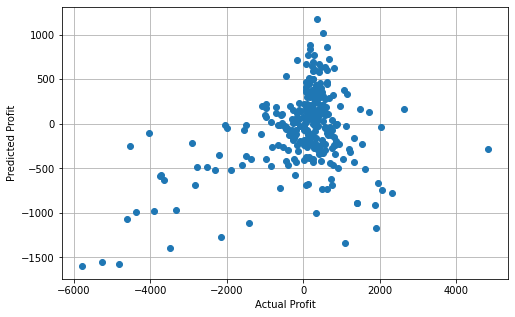

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, lasso_best_model.predict(Xsc_val), 'o')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.grid()

# **Bonus material: Creating Coefficient Plots**
We see some of the coefficients have decreased in absolute size and others have fully gone to 0. This is good to see, especially for features with high p-values (low statistical significance). We see what happens to coefficients as regularization increases:

TypeError: ignored

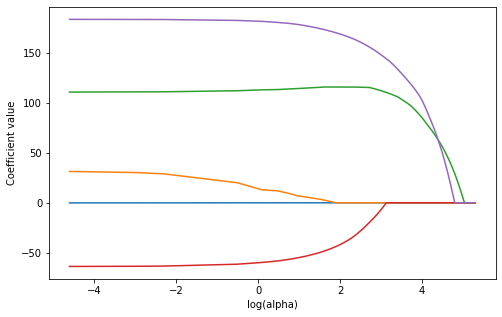

In [78]:
alphas = [0.05,0.01,0.05] + list(np.arange(0.1,200.5,0.5))
features = ['checking_account_3','purpose_6','employment_duration_1', 'property_1', 'gender_male']
feature_dicts = {feature: {} for feature in features}
for alpha in alphas:
    lasso_model_ = Lasso(alpha=alpha)
    lasso_model_.fit(Xsc_train, y_train)
    coefs = dict(zip(X.columns, lasso_model_.coef_))
    for feature in features:
        feature_dicts[feature][alpha] = coefs[feature]
        
plt.figure(figsize=(8,5))
for feature, feature_dict in feature_dicts.items():
    plot_x = sorted(list(feature_dict.keys()))
    plot_y = [feature_dict[x_i] for x_i in plot_x]
    plt.plot(np.log(plot_x), plot_y, label=feature)
plt.xlabel('log(alpha)')
plt.ylabel('Coefficient value')
plt.legend();

In [77]:
alphas = [0.05,0.01,0.05,0.1,0.5] + list(np.arange(1,25000,5))
features = ['checking_account_3','purpose_6','employment_duration_1', 'property_1', 'gender_male']
feature_dicts = {feature: {} for feature in features}
for alpha in alphas:
    ridge_model_ = Ridge(alpha=alpha)
    ridge_model_.fit(Xsc_train, y_train)
    coefs = dict(zip(X.columns, ridge_model_.coef_))
    for feature in features:
        feature_dicts[feature][alpha] = coefs[feature]
        
plt.figure(figsize=(8,5))
for feature, feature_dict in feature_dicts.items():
    plot_x = sorted(list(feature_dict.keys()))
    plot_y = [feature_dict[x_i] for x_i in plot_x]
    plt.plot(np.log(plot_x), plot_y, label=feature)
plt.xlabel('log(alpha)')
plt.ylabel('Coefficient value')
plt.legend(loc='upper left', frameon=False)
#plt.legend()

KeyboardInterrupt: ignored